In [7]:
# Required libraries

#conda install -c conda-forge librosa 
#python 3.7 to support tensorflow 2

#conda install scikit-learn librosa

import sys
import os
import IPython as IP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [9]:
# Set your path to the dataset
us8k_path = os.path.abspath('data/UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

In [10]:
import pandas as pd
# Load the metadata from the generated CSV
metadata =pd.read_csv(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


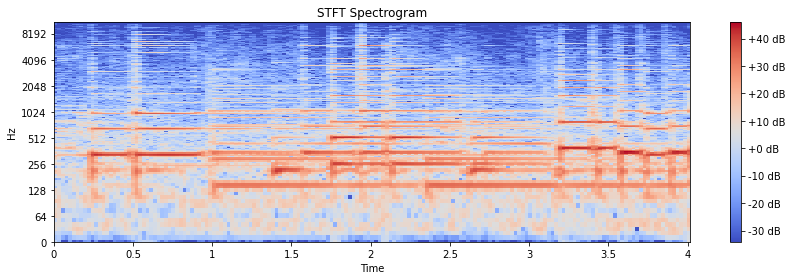

In [11]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
# Get a random file
row = metadata.sample(1)
file_path = audio_path + '/fold'+ str(row.iloc[0,5]) +'/' + str(row.iloc[0,0])

# Windowing
n_fft=2048
hop_length=512

# Load audio file
y, sr = librosa.load(file_path)

# Normalize between -1 and 1
normalized_y = librosa.util.normalize(y)

# Compute STFT
stft = librosa.core.stft(normalized_y, n_fft=n_fft, hop_length=hop_length)

# Convert sound intensity to log amplitude:
stft_db = librosa.amplitude_to_db(abs(stft))


# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()

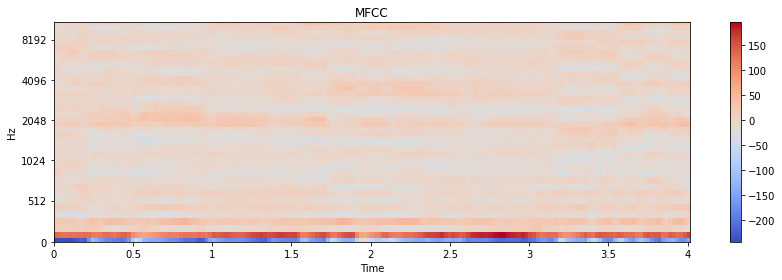

In [12]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=40)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

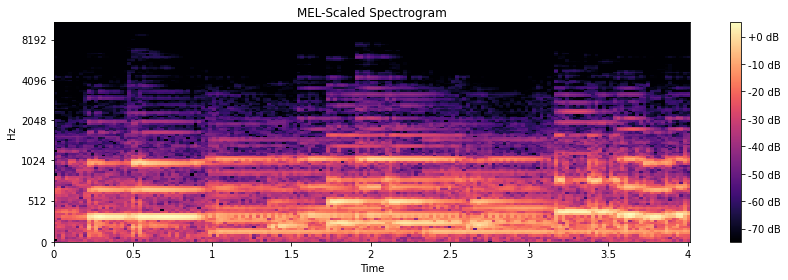

In [13]:
n_mels = 128

# Generate mel scaled spectrogram
mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mels)

# Convert sound intensity to log amplitude:
mel_db = librosa.amplitude_to_db(abs(mel))

# Normalize between -1 and 1
normalized_mel = librosa.util.normalize(mel_db)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');
plt.title('MEL-Scaled Spectrogram')
plt.tight_layout()
plt.show()

In [14]:
# Generates/extracts MFCC coefficients with LibRosa 
def get_mfcc(file_path, mfcc_max_padding=0, n_mfcc=40):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Normalize audio data between -1 and 1
        normalized_y = librosa.util.normalize(y)

        # Compute MFCC coefficients
        mfcc = librosa.feature.mfcc(y=normalized_y, sr=sr, n_mfcc=n_mfcc)

        # Normalize MFCC between -1 and 1
        normalized_mfcc = librosa.util.normalize(mfcc)

        # Should we require padding
        shape = normalized_mfcc.shape[1]
        if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mfcc = np.pad(normalized_mfcc, pad_width=((0,0), (xLeft, xRight)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", e)
        return None 
    return normalized_mfcc

In [15]:
import os
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mfcc = 40

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath(audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]

    # Extract MFCCs (do not add padding)
    mfccs = get_mfcc(file_path, 0, n_mfcc)
    
    # Save current frame count
    num_frames = mfccs.shape[1]
    
    # Add row (feature / label)
    features.append(mfccs)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 501/8732
Status: 1001/8732
Status: 1501/8732
Status: 2001/8732
Status: 2501/8732
Status: 3001/8732
Status: 3501/8732


/Users/manjuvallayil/miniforge3/envs/TeReo-gpu/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(


Status: 4001/8732
Status: 4501/8732
Status: 5001/8732
Status: 5501/8732
Status: 6001/8732
Status: 6501/8732
Status: 7001/8732
Status: 7501/8732
Status: 8001/8732


/Users/manjuvallayil/miniforge3/envs/TeReo-gpu/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/Users/manjuvallayil/miniforge3/envs/TeReo-gpu/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


Status: 8501/8732
Finished: 8731/8732


In [16]:
# Given an numpy array of features, zero-pads each ocurrence to max_padding
def add_padding(features, mfcc_max_padding=174):
    padded = []

    # Add padding
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < mfcc_max_padding):
            xDiff = mfcc_max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

In [17]:
import numpy as np
# Add padding to features with less than frames than frames_max
padded_features = add_padding(features, frames_max)

In [18]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


In [19]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

# Optionally save the features to disk
np.save("data/X-mfcc", X)
np.save("data/y-mfcc", y)

In [20]:
# Generates/extracts Log-MEL Spectrogram coefficients with LibRosa 
def get_mel_spectrogram(file_path, mfcc_max_padding=0, n_fft=2048, hop_length=512, n_mels=128):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Normalize audio data between -1 and 1
        normalized_y = librosa.util.normalize(y)

        # Generate mel scaled filterbanks
        mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)

        # Convert sound intensity to log amplitude:
        mel_db = librosa.amplitude_to_db(abs(mel))

        # Normalize between -1 and 1
        normalized_mel = librosa.util.normalize(mel_db)

        # Should we require padding
        shape = normalized_mel.shape[1]
        if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", e)
        return None 
    return normalized_mel

In [21]:
# Iterate through all audio files and extract mel-spectrograms
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mels=40

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath(audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]

    # Extract Log-Mel Spectrograms (do not add padding)
    mels = get_mel_spectrogram(file_path, 0, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features.append(mels)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 501/8732
Status: 1001/8732
Status: 1501/8732
Status: 2001/8732
Status: 2501/8732
Status: 3001/8732
Status: 3501/8732
Status: 4001/8732
Status: 4501/8732
Status: 5001/8732
Status: 5501/8732
Status: 6001/8732
Status: 6501/8732
Status: 7001/8732
Status: 7501/8732
Status: 8001/8732
Status: 8501/8732
Finished: 8731/8732


In [22]:
# Add padding to features with less than frames than frames_max
padded_features = add_padding(features, frames_max)

In [23]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


In [24]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

np.save("data/X-mel_spec", X)
np.save("data/y-mel_spec", y)